In [2]:
import pandas as pd
import numpy as np
import urllib.parse
import urllib.request
import certifi
import ssl
from Bio import SeqIO
from pathlib import Path
from collections import Counter
from Bio.Seq import Seq
import multiprocessing
from tqdm import tqdm
from datetime import datetime


In [2]:
uniprot = pd.read_csv('../uniprot_reviewed.tab',sep='\t')
uniprot.head()

,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM),Cross-reference (CAZy)
0,Q4R8P0,ABHGA_MACFA,558,3.1.-.-; 3.1.1.23,PF00561;,Eukaryota,NaN
1,P03949,ABL1_CAEEL,1224,2.7.10.2,PF08919;PF07714;PF00017;PF00018;,Eukaryota,NaN
2,Q9NPB9,ACKR4_HUMAN,350,NaN,PF00001;,Eukaryota,NaN
3,P31937,3HIDH_HUMAN,336,1.1.1.31,PF14833;PF03446;,Eukaryota,NaN
4,Q9FFR3,6PGD3_ARATH,487,1.1.1.44,PF00393;PF03446;,Eukaryota,NaN


In [5]:
len(uniprot)

562253

In [6]:
prok_uniprot = uniprot[(uniprot['Taxonomic lineage (SUPERKINGDOM)']=='Archaea') | (uniprot['Taxonomic lineage (SUPERKINGDOM)']=='Bacteria')]
print(len(prok_uniprot))
print(len(set(prok_uniprot['Entry'])))
print(len(set(prok_uniprot['EC number'])))

354095
354095
3624


In [7]:
#need to have EC number for fn classification
prok_uniprot = prok_uniprot.dropna(subset=['EC number'])
print(len(prok_uniprot))
print(len(set(prok_uniprot['Entry'])))
print(len(set(prok_uniprot['EC number'])))
prok_uniprot.head()

206819
206819
3623


,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM),Cross-reference (CAZy)
11,P0CW05,ACKA_METMA,408,2.7.2.1,PF00871;,Archaea,NaN
15,B5XI22,ACPS_STRPZ,118,2.7.8.7,PF01648;,Bacteria,NaN
16,Q0AF73,ACPS_NITEC,125,2.7.8.7,PF01648;,Bacteria,NaN
17,B1Z872,ACPS_METPB,136,2.7.8.7,PF01648;,Bacteria,NaN
18,A5US51,ACPS_ROSS1,138,2.7.8.7,PF01648;,Bacteria,NaN


# link uniprot IDs to EMBL CDS IDs

In [8]:
#use the uniprot mapper to go from uniprotkb_id to cds id
#do it in chunks b/c too big for api

print('linking to EMBL CDS ids...')
fout = '../swissprot2cds.tsv'
num_chunks = 1000 #have to do in chunks or api crashes
interval = int(len(prok_uniprot)/num_chunks)+1
starts = [x*interval for x in range(0,num_chunks)]
stops = [x*interval for x in range(1,num_chunks+1)] 
url = 'https://www.uniprot.org/uploadlists/'

def get_response(query):
    #query = ' '.join(prok_uniprot['externalID'][starts[ix]:stops[ix]])
    fout = '../swissprot2cds.tsv'
    params = { 
    'from': 'ACC+ID', #uniprot KB id
    'to': 'EMBL', #EMBL/GenBank/DDBJ CDS
    'format': 'tab', 
    'query': query
    } 
    try:
        data = urllib.parse.urlencode(params) 
        data = data.encode('utf-8') 
        req = urllib.request.Request(url, data) 
        with urllib.request.urlopen(req, context=ssl.create_default_context(cafile=certifi.where())) as f:
            response = f.read() 
        with open(fout,'a') as f:
            f.writelines(response.decode('utf-8').split('From\tTo\n')[1])
    except:
        print('error with query: ', data)
        pass

queries = [' '.join(prok_uniprot['Entry'][starts[ix]:stops[ix]]) for ix in range(0,num_chunks)]
start = datetime.now()
for query in tqdm(queries):
    get_response(query)
end = datetime.now()
print('took',end-start,'to process',num_chunks,'queries')


  0%|          | 0/1000 [00:00<?, ?it/s]

linking to EMBL CDS ids...


 20%|██        | 200/1000 [40:00<1:49:44,  8.23s/it]

error with query:  b'from=ACC%2BID&to=EMBL&format=tab&query=Q5HQE7+Q89UG3+Q81IA1+Q817Z5+A6VTV6+Q8YHZ6+A1RIY2+Q18BJ5+P58741+B2KAA6+Q831R1+Q6D7B4+P0DH36+Q81G27+P43672+C1CR90+Q13W85+Q2YYQ6+C0MCM8+B1AJ73+Q1CKJ9+Q0K7S4+B2RZW9+A8GA20+P31307+Q49ZB5+C1CXS7+Q1C5B3+P0CB00+Q1LSL8+Q47G54+B2IIJ1+A1KBB4+Q5L4Q4+A7MJT8+Q1QV52+O54420+Q9PJD2+A1KBB5+A9KCD5+Q9JUC4+Q04BG7+B9J8M3+B2HSZ2+A5VIJ2+Q1IBP1+B7IR00+B8FX50+B5XNF8+Q8A9J0+P0A6L8+P18314+B8HA07+A2SDJ1+Q89WG0+P0A2D2+A7FQG8+Q0K998+Q1J8H6+P0DH30+B1J4J3+Q87VP0+P9WFF2+Q9RB37+Q83HQ7+Q3SWA8+A1JQW4+C5CBT8+A9MC99+B5R0R3+B1LF94+A6U3J7+Q6GEW3+B1J8R9+A6UWS5+A5UMH8+Q5WB67+Q39KB9+P67076+B7MLJ7+Q96ZM1+A8A2Z0+B4TFD0+B3PXN0+B9KYE6+Q57GJ4+B0R7K0+P45821+Q1AVX3+Q7NE68+Q5FUJ4+C1FUF9+A5IS30+Q6MIG1+Q8FNU1+Q28KP2+Q5HPC0+O33160+B7MNV0+P96188+Q83QN4+B0UL80+B2KDP9+A9KV69+Q8RD35+Q46WZ4+Q1BZG3+Q9X105+A4VZ51+Q5X1S7+Q5HGU0+O32855+B7UV38+B2RK20+Q3STS7+C1ETZ0+A4TBE7+A2RKV4+C0MEM8+Q9HVW7+A6VC58+Q3ZV00+B2RIF2+B7JWN0+Q8ESR4+Q3AMB9+Q98KB5+P59963+Q2JW21+A5VJ33+A4VSW4+Q0VS04+B1LC69+A1VBE8+C5

 20%|██        | 201/1000 [40:00<1:17:42,  5.84s/it]

error with query:  b'from=ACC%2BID&to=EMBL&format=tab&query=P63955+P0A109+Q8KBH1+Q2RXI0+P0A5L9+Q3AMB7+O67238+Q5ZRQ7+B1JXB7+B3GZK8+Q8D2Z1+Q52126+A2BU83+Q2NX35+Q48V28+Q8ZLQ6+Q57896+P74528+B2K721+A1B2U9+Q1JGW5+Q7VNI8+Q0HGL3+B2VEC5+A8G244+B0JLU4+A8ZWU7+O86042+Q49WD6+A9N833+A8ALW2+B4TU54+A2RKU2+Q984N8+A1BEP5+Q2Y6F2+P63949+A4J0S4+A4SP05+Q4A094+Q2KY86+Q9CKB3+O83455+Q926V7+Q1C5U9+B7IE73+P43802+C3M9D7+P65536+B2TDV9+Q7NND8+B6I1U0+A1BJI4+Q87VL4+P09152+Q8CWY4+B4SSW2+Q2JT69+B7GTM7+Q72NR0+B2GA98+Q65Q72+Q58747+Q8TVH1+B0JHT4+Q8CVW4+Q2JWB1+Q5ZVU5+Q31Z29+B1IY66+Q3M880+Q1CK03+Q7MJ90+A4XYY3+A1JL26+Q66D87+C5A4G1+A4Y9F2+Q0HVB6+Q9KD91+Q9X1X7+Q8K9B7+Q2YL69+Q7DDR9+C3MU99+Q53U08+Q735N7+A1JIJ2+Q8XQB8+A9N0L0+B7VKD6+O67377+Q82SE7+B5F1I1+Q51705+Q51296+B7LA92+Q9RFV6+A0LH11+B4RNF8+B4T2V2+Q56587+B6IUZ1+Q3KKV3+A5IVH3+Q3Z3B7+Q9K0M6+Q9K0M4+Q7MID2+A5VA47+Q9CLB0+Q75R62+P29914+A5UAX2+A3D139+Q21JS2+Q9KPS1+Q9PKB6+P55356+B5FEY0+B3E9H6+B5FG80+Q8KEC3+Q0S447+Q5GS15+A7ZQE0+Q10YT3+B5FPG7+Q48H47+P0CH29+Q1MIL2+Q11JK4+Q2W3I6+A0LRI9+Q2

 20%|██        | 204/1000 [40:21<1:16:45,  5.79s/it]

error with query:  b'from=ACC%2BID&to=EMBL&format=tab&query=B2U4P9+Q9JW05+Q1JG69+P45097+B2G5A3+Q7NSB9+A7GMN5+Q15YC5+Q9HIM0+A8LIN6+Q5WSS7+Q7VL22+B7N3A7+Q65RE8+B0SX50+A6TVS0+P65951+A3MSP1+Q3ILB9+B5ZPR8+C0ZZY4+A8GR69+Q02PL5+Q0BBX9+C0QST3+Q5LFI5+B0T410+Q1LT62+A5WGS3+Q31YK8+B5R8M3+Q46920+Q6GAF4+Q0BQ87+Q6N5T4+Q72IN0+Q9F1U7+A5VNQ1+P34958+Q1Q9K1+A3N0D6+C5A7F1+B1W464+A3N0A0+Q7WCA8+A0AEN2+Q4QLA8+Q8D2K0+B2U9C0+C4XPD6+Q5WX86+Q98B89+Q15UB7+Q2FWD1+Q9HKM2+A1AEY1+B1HPF6+Q9Z9C8+A8I5Q2+P0DD71+B6J1D4+A8ZWP0+A5F6Y1+Q0I677+A5TZA9+A6VSX4+Q38X21+C1D6F5+Q65GP8+Q5E0G4+Q62J08+P42106+B8DDR4+Q02XW6+Q5PBX6+A5UGX0+Q12XW6+Q0VQD8+Q9F4I7+Q2JJ22+Q609Z8+A5EK53+Q7A698+Q485G8+Q64YI2+Q8R6G5+Q2W156+A9MVN7+A3PXZ4+Q6DB93+Q3AN25+A6QG99+C6DJF8+Q9PN24+Q7UNR3+P65931+A2RG31+Q8U122+Q5HGH3+P0CB75+A1RRX6+A6QB35+Q6GHH7+Q5PD61+Q67PB5+P31473+A2SH96+O50581+Q46GN1+B2GCY7+Q07RX1+Q2YY57+A7Z5Y2+Q7V6F8+A8Z429+Q673V5+Q44176+Q9K6J9+A9QYG7+A0QS30+Q5FJ20+Q83PJ1+A3PRW6+Q5KUX3+Q7NA80+P27997+Q1BPL3+B7JQF1+A9N598+Q9CF44+A6VKS7+O32740+Q926R0+Q57HG9+Q8

 26%|██▌       | 257/1000 [50:03<1:34:56,  7.67s/it]

error with query:  b'from=ACC%2BID&to=EMBL&format=tab&query=P65918+B1JVY9+B2TTV6+B4TZY3+B2HNE5+C3LNL5+Q81WF0+B2SHJ1+Q5PBQ6+Q3AZD9+A7GRL3+O83985+B1M7M3+A8A8H6+Q9KVD5+A2BUL3+Q6GA15+A1KWH8+Q3A397+B9MEQ7+B8HNM9+Q163C5+A4YVG4+A8AAG3+Q7UYX5+Q2S6J2+A4W6R6+B8GTF1+A7Z4G7+Q39W86+A8FMY0+Q11HU6+B0BBG3+Q30SN5+Q8G0D7+A1SYZ6+P98004+Q7MAD7+Q7WJ92+A4TBY0+Q1LSV5+C1CR28+Q0T838+Q313G6+A6Q311+Q9PKL0+Q21I34+Q0TAW3+Q5NHX8+Q47S51+B4TWU3+A3DGR3+B7HHV4+B0U2I4+Q6GGW0+A1JNM3+Q5HP94+Q03S30+Q03MI3+Q9Z7G7+B9DV63+A4VZM0+B1I9H0+Q57HW2+Q9CF42+Q31UM5+Q8E7N8+B5BIQ2+Q7UU60+Q56260+B2GEJ1+Q8D7T8+Q65E56+Q664G2+Q28P50+B9KTC8+Q93A90+Q54089+Q46E16+Q9Y9D9+P0A0F0+Q59459+P0A0E9+B7LVD9+A8APS7+Q8TH04+P14168+Q8KA55+Q0TD60+O67226+Q9UZ86+P26402+B1YMY7+B1ISB5+C5BHH8+Q1R418+B2VGK1+A6U608+B0VQB7+B5BIS9+B8GJN8+Q889Q6+Q8Y3I9+Q7VK48+B0V709+P39452+A6VLD6+P61713+A6VFN4+Q5LCF8+Q6CZD9+Q87KH5+B0RWT6+O05262+B5F0M7+P9WK35+Q9UZ37+A8A6N4+Q323Z6+B5EK28+A3D9I5+Q66FF4+Q1BGJ0+B5RG86+A0RTV6+B2TFM7+A2STY4+Q87D69+A7GSD5+A4FLW9+Q5HF07+Q085K0+A9F1Y8+Q0TK29+Q3

 34%|███▍      | 342/1000 [1:06:30<1:25:48,  7.82s/it]

error with query:  b'from=ACC%2BID&to=EMBL&format=tab&query=B6HZ64+Q18F47+Q3K1I2+P56422+Q88G95+Q57278+Q0BQ80+Q7ME63+Q979C3+B7L8W6+Q8NQ73+A7ZB87+Q58247+Q9ZL45+A1KHW1+Q0TPG4+C7Q4X5+Q0RCR9+Q8Q0M5+Q87PK5+Q3K955+P0CB59+A9QYH5+Q1JAG8+Q1BTX7+B0KQW4+Q7VLN2+A0LWI8+Q1WT98+B1KL44+B0UUN5+A1UKE3+B9DPR2+Q1GYZ8+C4XRE5+Q1CMN0+Q604V7+A5CXA6+B2SNZ1+B0JUK9+A5F5N2+A0LNZ0+O25235+B5ZWJ7+P74529+Q7MWM6+A6WZQ3+C1AU58+A8LDL3+Q87KP5+Q6N7A6+Q8ZYF8+D2S4P5+C5CA33+B7GV74+Q5E2Q1+Q1B6X1+A8GVM4+Q97F79+A7HH68+O83128+Q0T0J4+C4K1S5+Q5L9P3+A9M7U1+B8G5Y3+A8FQA0+B5XZW3+P57466+A1TKY2+Q3A2G6+Q8E069+A7FLL0+A3N1T6+B9DY44+A1V9N9+Q4L805+Q04QY0+Q65RY7+Q0VS40+A5VNK4+A5FIY4+Q46WZ5+Q9A5A6+B1IX44+C4XK68+O33159+P61681+B2S906+Q0T280+A3DAG6+B8EBS7+A5D0W6+Q8Q083+Q5WEK0+Q65R16+Q9I340+B2V583+A5UIK7+Q319I9+A4QFM2+B1HX90+B4SH48+B3R7A2+Q6LL16+Q3SW27+A6V7A8+Q12FD4+A9R2Z8+P17952+Q313Q1+A7Z7E7+B0KQJ3+A5IAW3+B2UUR4+Q9RYU5+Q2FRN2+Q8NNN5+Q03ES4+Q3KKT1+B2SGS8+Q7N068+B3E4X8+Q5WTI8+Q6LMC9+Q2Y636+Q5PDC2+Q5F6L6+Q8X9Y8+B1IAM4+O32866+A8Z1T2+Q5LY40+Q7VAM1+A0

 50%|█████     | 500/1000 [1:37:23<1:34:34, 11.35s/it]

error with query:  b'from=ACC%2BID&to=EMBL&format=tab&query=A7NQB8+B3R1Z6+B7M6K1+B8G664+Q9WYK8+C4LIR6+Q183T0+A6L4N0+A6TFW3+Q5WKW1+P42094+B9M5K2+Q57QC4+Q83D18+B5YF84+C3KYR4+Q2FYD8+Q8Y5G1+A4SNJ1+B7JBC8+Q9KIG4+A6VQ68+Q1GMA8+Q03UX8+Q8PZK7+Q3SNS9+Q8XU38+T2KLZ3+A0PPN3+Q2IN45+P18187+P0DOB7+Q5W252+P75476+P21777+Q5W269+P9WI76+Q8NUV4+P20041+Q5WEF6+Q2JLH7+B7M6W7+B7NFL3+Q8XU39+P12625+A6U2G5+I3R9Z4+B0UW05+B7LVC9+Q4QLS8+Q82T07+C6A0Y7+Q8KFW8+Q7VEU7+P9WI70+Q5Z066+P20586+Q10Z46+B1XCR9+B8E0T1+P62419+B2IMA2+A9MZE7+Q51718+Q76HM7+Q3YYB9+D9TT10+P33377+Q0TV42+Q2YV52+A4Y3S0+Q3Z2Z2+B7ITJ6+B7N3N7+P94868+Q81PE9+Q2JJN4+B6ER23+A3D789+P47266+P75092+A8H5I0+Q7MDF5+C3LED0+Q1IQ54+P65806+B8CR94+Q7TXW0+B2A578+A6X570+A5IMD8+A3D3B2+Q9CEI6+Q46JM7+A9BH73+C3MA95+B5ZBQ1+Q5XEF9+Q48E81+Q1MIS7+A6QGC9+Q8XXP6+A3PJ65+Q21YD1+C1C6I5+B4TVU1+A3PY93+A5W983+Q8YEB7+Q1QZ10+B7GNH2+P73933+Q2J2J4+B2TJ61+A6WRG3+P57191+B2K759+P22751+B9KH94+C3MC71+Q1QEN9+A1WZI0+A7HLA7+B1LBY0+A9BNB8+Q5F8C7+A4W5F4+Q4KIF2+Q38X02+B0TY16+B1XGX6+P22253+Q602S2+A9KEA2+Q0

 54%|█████▎    | 536/1000 [1:44:26<1:21:25, 10.53s/it]

error with query:  b'from=ACC%2BID&to=EMBL&format=tab&query=A9MQC5+B1W2Y7+B1IXI5+Q46810+P49307+Q74JY6+A9BGS8+P0DB42+Q8CNE5+B5XYW4+Q98MK2+A7FLL2+A7MWL2+B5XLF2+A5WPA3+A4QGX4+C0PYY5+Q5WTI4+Q5WY98+C0R4W3+A9A1T2+Q6AE61+B0US64+B3QFN4+Q7N6P5+Q816X6+Q87A76+B0TMA7+A7MGS5+A7Z3X1+Q82VS3+P65482+B1KTF0+Q7W2Y6+Q9R4A1+Q5WYX3+B8FBR7+B1LGW2+Q07YV9+A1AWE8+C5D4X9+A1VBE9+A7FY72+Q11GS5+A4XQS4+Q39CQ5+Q2T1F6+B9MG14+A3MXH2+Q6A7E9+Q4FPD2+Q7U550+B9KGP6+P19213+A9GEU3+Q5FF20+A5GML7+A7FK39+Q2SHN2+Q8P0C4+B7MCH6+C4L415+A0PYX6+B0K889+B0R6I6+Q1JU72+B2GG36+Q9K152+B8FSD4+B7M611+Q7MWA2+A7NET9+B5ZN24+Q03EM9+A4QEV1+B7UNC6+Q052B5+A3PEE0+A9KUK2+Q894Z2+B5E3K2+A0KU09+A8A6R7+A4TE25+Q1MQJ1+Q2JW63+A7HID3+Q7TW52+A5VJD5+Q2NI00+B8DZX8+P06710+A3D5Y2+A0B6K6+Q8YW98+A7ZED8+P43746+O68045+Q819Y5+P00372+P57172+Q7MMT5+Q2FGY5+A6LA55+B5R3V4+B2V7S8+A8L538+C3NDY5+Q6LYM1+Q14GL3+Q5YRS7+Q3IS55+B8JBM1+A7IAA9+A5UD04+A7MKW4+Q031P9+Q89FV8+Q8E084+Q97JS8+B2K6T7+Q92BZ0+Q9PB95+Q5YVN7+Q1J449+Q5LXJ3+A6L5G8+Q9KTD1+Q6LX68+Q1MRB3+B5EP61+Q5HM28+B3DPR8+Q9PPV2+C3

100%|██████████| 1000/1000 [3:16:01<00:00, 12.16s/it] 

took 3:16:01.219674 to process 1000 queries


In [10]:
#rename columns
uniprot2cds = pd.read_csv(fout,sep='\t')
print(len(uniprot2cds))
uniprot2cds.columns = ['Entry','EMBL_CDS_id']
uniprot2cds.head()

229854


,Entry,EMBL_CDS_id
0,B5XI22,ACI61684.1
1,Q0AF73,ABI60009.1
2,B1Z872,ACB80392.1
3,A5US51,ABQ89454.1
4,Q0T128,ABF04987.1


In [20]:
merged = prok_uniprot.merge(uniprot2cds,on='Entry')
print(len(merged))
merged.head(10)

229854


,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM),Cross-reference (CAZy),EMBL_CDS_id
0,B5XI22,ACPS_STRPZ,118,2.7.8.7,PF01648;,Bacteria,NaN,ACI61684.1
1,Q0AF73,ACPS_NITEC,125,2.7.8.7,PF01648;,Bacteria,NaN,ABI60009.1
2,B1Z872,ACPS_METPB,136,2.7.8.7,PF01648;,Bacteria,NaN,ACB80392.1
3,A5US51,ACPS_ROSS1,138,2.7.8.7,PF01648;,Bacteria,NaN,ABQ89454.1
4,Q0T128,AAS_SHIF8,719,2.3.1.40; 6.2.1.20,PF01553;PF00501;,Bacteria,NaN,ABF04987.1
5,Q5H1F6,ACCA_XANOR,319,2.1.3.15,PF03255;,Bacteria,NaN,AAW75215.1
6,Q8P2X6,ACKA_STRP8,398,2.7.2.1,PF00871;,Bacteria,NaN,AAL96923.1
7,Q1LCS4,3HAO_CUPMC,174,1.13.11.6,PF06052;,Bacteria,NaN,ABF12052.1
8,B8HSZ5,ACCA_CYAP4,325,2.1.3.15,PF03255;,Bacteria,NaN,ACL42792.1
9,A1VAA0,ACKA_DESVV,402,2.7.2.1,PF00871;,Bacteria,NaN,ABM27366.1


In [12]:
Counter(merged['Taxonomic lineage (SUPERKINGDOM)'])

Counter({'Bacteria': 217942, 'Archaea': 11912})

In [35]:
#need to remove any entries with multiple EC numbers for our purposes
merged = merged[~merged['EC number'].str.contains(';')]
print(len(merged))
print(Counter(merged['Taxonomic lineage (SUPERKINGDOM)']))
merged.head()

217447
Counter({'Bacteria': 206133, 'Archaea': 11314})


,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM),Cross-reference (CAZy),EMBL_CDS_id
0,B5XI22,ACPS_STRPZ,118,2.7.8.7,PF01648;,Bacteria,NaN,ACI61684.1
1,Q0AF73,ACPS_NITEC,125,2.7.8.7,PF01648;,Bacteria,NaN,ABI60009.1
2,B1Z872,ACPS_METPB,136,2.7.8.7,PF01648;,Bacteria,NaN,ACB80392.1
3,A5US51,ACPS_ROSS1,138,2.7.8.7,PF01648;,Bacteria,NaN,ABQ89454.1
5,Q5H1F6,ACCA_XANOR,319,2.1.3.15,PF03255;,Bacteria,NaN,AAW75215.1


In [23]:
merged.to_csv('../swissprot_prok_with_cds.csv',index=False)

In [6]:
merged = pd.read_csv('../swissprot_prok_with_cds.csv')
print(merged.shape)
merged.head()

(217447, 8)


,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM),Cross-reference (CAZy),EMBL_CDS_id
0,B5XI22,ACPS_STRPZ,118,2.7.8.7,PF01648;,Bacteria,NaN,ACI61684.1
1,Q0AF73,ACPS_NITEC,125,2.7.8.7,PF01648;,Bacteria,NaN,ABI60009.1
2,B1Z872,ACPS_METPB,136,2.7.8.7,PF01648;,Bacteria,NaN,ACB80392.1
3,A5US51,ACPS_ROSS1,138,2.7.8.7,PF01648;,Bacteria,NaN,ABQ89454.1
4,Q5H1F6,ACCA_XANOR,319,2.1.3.15,PF03255;,Bacteria,NaN,AAW75215.1


# download CDS seqs

In [107]:
def get_seqs(ids,fout):
    #need do it in chunks of 500
    starts = list(np.arange(0,len(ids),500))
    stops = list(np.arange(500,len(ids),500))+[len(ids)]
    root = 'https://www.ebi.ac.uk/ena/browser/api/fasta/'
    
    for ix in tqdm(range(0,len(starts))):
        url = root+','.join(ids[starts[ix]:stops[ix]])
        response = urllib.request.urlopen(url, context=ssl.create_default_context(cafile=certifi.where())).read().decode('utf-8')
        with open(fout,'a') as f:
            f.writelines(response)
            

In [25]:
print('getting mifaser classification test set')
get_seqs(list(merged['EMBL_CDS_id']),fout='swissprot_test.fasta')


  0%|          | 0/435 [00:00<?, ?it/s]

getting mifaser classification test set



 67%|██████▋   | 290/435 [4:04:47<1:14:09, 30.69s/it]


100%|██████████| 435/435 [4:59:50<00:00, 20.69s/it]

# get clean csv

In [61]:
def generate_chunked_reads(seq, distrib, num_reads):
    chunked_seqs = []
    #if seq length is <60, just return that one sequence with forward and reverse
    if len(seq)<=60:
        chunked_seqs.append(seq)
        chunked_seqs.append(str(Seq(seq).reverse_complement()))
    else:
        for read in range(0,num_reads):
            #pick random start position, don't let it start farther than 60nt from end so all the reads are at least that long
            start = np.random.choice(range(0,len(seq)-60))
            if start < 0:
                start=0
            seqlen = int(np.random.choice(distrib))
            end = start+seqlen
            sequence = seq[start:end]
            #IRL, gene is equally likely to be sequenced in either forward or reverse direction. Toss a coin which to use
            use_complement = np.random.choice([0,1])
            if use_complement:
                subseq = str(Seq(sequence).reverse_complement())
            else:
                subseq = sequence
            chunked_seqs.append(subseq)
        
    return chunked_seqs

def create_csv(outfile, ref_df, in_path, distrib):
    records = []
    num_empty = 0
    #get the records and link to temp label
    for record in SeqIO.parse(in_path,"fasta"): 
        seq = str(record.seq)
        cds_id = record.description.split('|')[2].split(' ')[0]
        subset = ref_df[ref_df['EMBL_CDS_id']==cds_id]['EC number']
        if len(subset)>0:
            label = str(subset.iloc[0]) 
            #split into read-length chunks
            chunked_seqs = generate_chunked_reads(seq,distrib, num_reads=10)
            for read in chunked_seqs:        
                entry = [cds_id, read, label]
                records.append(entry)
        else:
            num_empty += 1
    print('number of non-matched cds ids:',num_empty)
    #shuffle records)
    outdf = pd.DataFrame(records)
    outdf = outdf.sample(frac=1)
    outdf.columns = ['EMBL_CDS_id','seq','annotation']
    print('saving',len(outdf),'rows in file',outfile,':')
    print(outdf.head())
    outdf.to_csv(outfile,index=False)

In [52]:
distrib = np.load('../GTDBGenomeSequencingDistrib.npy')

test_path = Path('swissprot_test.fasta')

testout = Path('swissprot_test.csv')

In [53]:
#save test
create_csv(outfile=testout, ref_df=merged, in_path=test_path, distrib=distrib)

number of non-matched cds ids: 101
saving 2181018 rows in file swissprot_test.csv :
        EMBL_CDS_id                                                seq  \
2133779  ABD05026.1  TTCCCTATTGCCTGTTTCTCGCCTCCGGCGGCCACACCCAGATCGT...   
1017264  CCP45682.1  AGTGTATCGCGCAACCCGTCGTCGGGGGCGTGCAGCGACAGCGCCA...   
2132242  ABM45255.1  TTATTTTTTGATAAAAGTGAGATAAGTAGGTACTCTATTTTCACGC...   
299284   ACI51541.1  GTGCTGGCGACGGGGCGCTACACGCGGCGGCAATCGACGTGGTTTG...   
975495   ABI25961.1  ACCAAGTTCGTCAAAATTTACAATCTTCTGGTTTATGGACCGCACT...   

        annotation  
2133779  2.3.1.234  
1017264  2.1.1.192  
2132242   2.1.1.33  
299284    2.5.1.75  
975495     7.2.1.1  


In [54]:
merged.head()

,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM),Cross-reference (CAZy),EMBL_CDS_id
0,B5XI22,ACPS_STRPZ,118,2.7.8.7,PF01648;,Bacteria,NaN,ACI61684.1
1,Q0AF73,ACPS_NITEC,125,2.7.8.7,PF01648;,Bacteria,NaN,ABI60009.1
2,B1Z872,ACPS_METPB,136,2.7.8.7,PF01648;,Bacteria,NaN,ACB80392.1
3,A5US51,ACPS_ROSS1,138,2.7.8.7,PF01648;,Bacteria,NaN,ABQ89454.1
5,Q5H1F6,ACCA_XANOR,319,2.1.3.15,PF03255;,Bacteria,NaN,AAW75215.1


In [93]:
print(len(set(merged['EC number'])))
print(len(merged))
print(len(set(merged['EMBL_CDS_id'])))

2997
217447
217437


In [7]:
Counter(merged['EC number']).most_common()[0:10]

[('7.1.1.-', 3492),
 ('2.7.7.6', 3373),
 ('3.1.-.-', 3191),
 ('7.1.2.2', 1881),
 ('3.6.4.12', 1743),
 ('2.1.1.-', 1645),
 ('3.1.26.4', 1186),
 ('5.2.1.8', 1173),
 ('6.3.5.-', 1168),
 ('4.2.1.33', 1145)]

In [8]:
Counter(merged['EC number']).most_common()[-10:]

[('1.2.1.24', 1),
 ('1.1.1.339', 1),
 ('3.5.4.45', 1),
 ('2.1.1.327', 1),
 ('4.2.1.154', 1),
 ('2.1.1.304', 1),
 ('2.4.1.329', 1),
 ('3.1.3.97', 1),
 ('1.1.1.266', 1),
 ('2.7.3.13', 1)]

In [9]:
classes = np.load('mifaser_classes.npy')
len(classes)

1274

In [10]:
classes

array(['4.4.1.21', '1.4.99.5', '6.2.1.44', ..., '1.10.3.14', '5.3.1.13',
       '1.1.1.169'], dtype='<U11')

In [11]:
subset = merged[merged['EC number'].isin(list(classes))]

In [95]:
len(subset)

140876

In [96]:
subset.head()

,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM),Cross-reference (CAZy),EMBL_CDS_id
0,B5XI22,ACPS_STRPZ,118,2.7.8.7,PF01648;,Bacteria,NaN,ACI61684.1
1,Q0AF73,ACPS_NITEC,125,2.7.8.7,PF01648;,Bacteria,NaN,ABI60009.1
2,B1Z872,ACPS_METPB,136,2.7.8.7,PF01648;,Bacteria,NaN,ACB80392.1
3,A5US51,ACPS_ROSS1,138,2.7.8.7,PF01648;,Bacteria,NaN,ABQ89454.1
5,Q8P2X6,ACKA_STRP8,398,2.7.2.1,PF00871;,Bacteria,NaN,AAL96923.1


In [57]:
len(set(subset['EC number']))

1186

In [62]:
print('getting mifaser classification test set2')
get_seqs(list(subset['EMBL_CDS_id']),fout='swissprot_test_mifaserclasses.fasta')

  0%|          | 0/282 [00:00<?, ?it/s]

getting mifaser classification test set2


100%|██████████| 282/282 [1:32:48<00:00, 18.80s/it]


In [63]:
distrib = np.load('../GTDBGenomeSequencingDistrib.npy')

test_path2 = Path('swissprot_test_mifaserclasses.fasta')

testout2 = Path('swissprot_test_mifaserclasses.csv')

#save test
create_csv(outfile=testout2, ref_df=subset, in_path=test_path2, distrib=distrib)

number of non-matched cds ids: 0
saving 1400872 rows in file swissprot_test_mifaserclasses.csv :
        EMBL_CDS_id                                                seq  \
307953   ACL48366.1  AGTTCTGACGGAAGGTGGCGTGCAGCAGGGCTTCACGCGGGCCGGC...   
1193880  CAC30009.1  GCGGGTCGACTACCCAGACGAACGCCCAGGCCTCGGGGTCGATCAA...   
493028   ABJ73463.1  GTTGACCGTGTGAATGGAATTGTTACTGACGAAGTTGAATATTTGA...   
281319   ACO73607.1  TCGGCAGGCCGTGGCAGTCCCAGCCCGGCACATAGGGCGCATCAAA...   
749522   ABC20859.1  GCACGACGCGCCCGAGGTCCAATGCGCCAAGGCCGGCATCGACGCC...   

        annotation  
307953     2.7.7.4  
1193880   6.1.1.23  
493028     2.7.7.6  
281319     6.1.1.5  
749522     2.2.1.7  


In [64]:
#downsample or upsample to mean number of annotations so can fine tune classifier to swissprot 
test = pd.read_csv('swissprot_test_mifaserclasses.csv')
test.head()

,EMBL_CDS_id,seq,annotation
0,ACL48366.1,AGTTCTGACGGAAGGTGGCGTGCAGCAGGGCTTCACGCGGGCCGGC...,2.7.7.4
1,CAC30009.1,GCGGGTCGACTACCCAGACGAACGCCCAGGCCTCGGGGTCGATCAA...,6.1.1.23
2,ABJ73463.1,GTTGACCGTGTGAATGGAATTGTTACTGACGAAGTTGAATATTTGA...,2.7.7.6
3,ACO73607.1,TCGGCAGGCCGTGGCAGTCCCAGCCCGGCACATAGGGCGCATCAAA...,6.1.1.5
4,ABC20859.1,GCACGACGCGCCCGAGGTCCAATGCGCCAAGGCCGGCATCGACGCC...,2.2.1.7


In [72]:
counts = [c for x,c in Counter(test['annotation']).items()]
print(len(set(test['annotation'])))
print(np.mean(counts))
print(np.median(counts))
print(np.max(counts))
print(np.min(counts))

1185
1182.1704641350211
200.0
33580
10


In [86]:
def upsample_seqs(records,max_seqs):
    multiplier = int(max_seqs/len(records))
    new_records = multiplier*[records]
    return new_records

test_even = pd.DataFrame()
for ec in set(test['annotation']):
    sub = test[test['annotation']==ec]
    if len(sub) > 1182:
        #if too many, downsample to mean value of 1182
        sample = sub.sample(1182, replace=False)
        test_even = test_even.append(sample, ignore_index=True)
    elif len(sub) <= 1182:
        #if too few, upsample to mean value of 1182
        records = upsample_seqs(sub,1182)
        test_even = test_even.append(records, ignore_index=True)

In [87]:
print(test_even.shape)
counts = [c for x,c in Counter(test_even['annotation']).items()]
print(len(set(test_even['annotation'])))
print(np.mean(counts))
print(np.median(counts))
print(np.max(counts))
print(np.min(counts))

(1312730, 3)
1185
1107.789029535865
1160.0
1182
610


In [92]:
test_even.to_csv('swissprot_test_evenclasses.csv',index=False)

## split swissprot test set by uniref50 id

In [97]:
subset.head()

,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM),Cross-reference (CAZy),EMBL_CDS_id
0,B5XI22,ACPS_STRPZ,118,2.7.8.7,PF01648;,Bacteria,NaN,ACI61684.1
1,Q0AF73,ACPS_NITEC,125,2.7.8.7,PF01648;,Bacteria,NaN,ABI60009.1
2,B1Z872,ACPS_METPB,136,2.7.8.7,PF01648;,Bacteria,NaN,ACB80392.1
3,A5US51,ACPS_ROSS1,138,2.7.8.7,PF01648;,Bacteria,NaN,ABQ89454.1
5,Q8P2X6,ACKA_STRP8,398,2.7.2.1,PF00871;,Bacteria,NaN,AAL96923.1


In [98]:
test.head()

,EMBL_CDS_id,seq,annotation
0,ACL48366.1,AGTTCTGACGGAAGGTGGCGTGCAGCAGGGCTTCACGCGGGCCGGC...,2.7.7.4
1,CAC30009.1,GCGGGTCGACTACCCAGACGAACGCCCAGGCCTCGGGGTCGATCAA...,6.1.1.23
2,ABJ73463.1,GTTGACCGTGTGAATGGAATTGTTACTGACGAAGTTGAATATTTGA...,2.7.7.6
3,ACO73607.1,TCGGCAGGCCGTGGCAGTCCCAGCCCGGCACATAGGGCGCATCAAA...,6.1.1.5
4,ABC20859.1,GCACGACGCGCCCGAGGTCCAATGCGCCAAGGCCGGCATCGACGCC...,2.2.1.7


In [99]:
#link uniprot id to uniref50 id
import urllib.parse
import urllib.request

url = 'https://www.uniprot.org/uploadlists/'
query = ' '.join(list(set(subset['Entry'])))

params = {
'from': 'ACC+ID',
'to': 'NF50',
'format': 'tab',
'query': query
}

data = urllib.parse.urlencode(params) 
data = data.encode('utf-8') 
req = urllib.request.Request(url, data) 
with urllib.request.urlopen(req, context=ssl.create_default_context(cafile=certifi.where())) as f: 
    response = f.read() 

In [100]:
fout = 'swissprot_mifaserclasses_uniprot2uniref50.tsv'
with open(fout,'w') as f:
    f.writelines(response.decode('utf-8')) 

## split into train/valid/test so no overlapping uniref50 ids

In [101]:
clusters = pd.read_csv('swissprot_mifaserclasses_uniprot2uniref50.tsv',sep='\t')
clusters.columns = ['Entry','uniref50id']
print(len(clusters))
print(len(set(clusters['uniref50id'])))
clusters.head()

126631
24549


,Entry,uniref50id
0,B4EUW6,UniRef50_Q8CX44
1,Q8FPR0,UniRef50_Q9ZBS0
2,Q2J9A9,UniRef50_Q9X7S0
3,Q0BEH0,UniRef50_Q3JRF0
4,Q9AE11,UniRef50_Q9AE11


In [102]:
swissmerged = clusters.merge(subset[['Entry','EC number', 'EMBL_CDS_id']])

In [103]:
print(len(swissmerged))
print(len(swissmerged.dropna()))
print(len(set(swissmerged['uniref50id'])))
print(len(set(swissmerged['Entry'])))
print(len(set(swissmerged['EC number'])))

140875
140875
24549
126631
1186


In [104]:
swissmerged.to_csv('swissprot_mifaserclasses_merged2cds2uniref.csv',index=False)
swissmerged = pd.read_csv('swissprot_mifaserclasses_merged2cds2uniref.csv')
swissmerged.head()

,Entry,uniref50id,EC number,EMBL_CDS_id
0,B4EUW6,UniRef50_Q8CX44,2.1.1.228,CAR40985.1
1,Q8FPR0,UniRef50_Q9ZBS0,1.1.1.94,BAC18240.1
2,Q2J9A9,UniRef50_Q9X7S0,3.4.21.92,ABD12133.1
3,Q0BEH0,UniRef50_Q3JRF0,1.8.4.12,ABI87453.1
4,Q9AE11,UniRef50_Q9AE11,3.1.22.4,AAK19838.1


In [119]:
def get_split_df(df,column_to_split,val_pct,test_pct):
    valid_target_length = int(len(df)*val_pct)
    test_target_length = int(len(df)*test_pct)
    print('ideally, there will be 15% in valid set of both nrows and number of cats:',valid_target_length,int(len(set(df[column_to_split]))*val_pct))
    print('ideally, there will be 5% in test set of both nrows and number of cats:',test_target_length,int(len(set(df[column_to_split]))*test_pct))
    
    train = pd.DataFrame()
    valid = pd.DataFrame()
    test = pd.DataFrame()
    
    cats = list(set(df[column_to_split]))
    for ec in set(df['EC number']):
        subset = df[df['EC number']==ec]
        refid = list(set(subset[column_to_split]))
        if len(refid)==1:
            #if ec number only has one uniref50id, that entire uniref50id should go in train (so train set has every ec category and uniref50id split is maintained)
            subset = df[df[column_to_split]==refid[0]]
            train = train.append(subset)
            try:
                cats.remove(refid[0])
            except ValueError: #sometimes same uniref50id for multiple ec numbers (even if that ec number only has one uniref50id); in that case, dont' need to remove because already did
                pass

    for cat in cats:
        subset = df[df[column_to_split]==cat]        
        if len(test)<test_target_length:
            test = test.append(subset)
        elif len(valid)<valid_target_length:
            valid = valid.append(subset)
        else:
            train = train.append(subset)
            
    print('length original df:',len(df),'; number cats:',len(set(df[column_to_split])))
    print('length train:',len(train),'; number cats:',len(set(train[column_to_split])))
    print('length valid:',len(valid),'; number cats:',len(set(valid[column_to_split])))
    print('length test:',len(test),'; number cats:',len(set(test[column_to_split])))
    
    
    return train,valid,test

In [120]:
swiss_train,swiss_valid,swiss_test = get_split_df(swissmerged,'uniref50id',0.15,0.05)

ideally, there will be 15% in valid set of both nrows and number of cats: 21131 3682
ideally, there will be 5% in test set of both nrows and number of cats: 7043 1227
length original df: 140875 ; number cats: 24549
length train: 112726 ; number cats: 19771
length valid: 21136 ; number cats: 3515
length test: 7051 ; number cats: 1263


In [132]:
print(len(set(swissmerged['EC number'])))
print(len(set(swiss_train['EC number'])))
print(len(set(swiss_valid['EC number'])))
print(len(set(swiss_test['EC number'])))

1186
1184
617
445


In [122]:
swiss_valid.head()

,Entry,uniref50id,EC number,EMBL_CDS_id
135377,A0B6A6,UniRef50_A0B6A6,6.3.4.20,ABK14230.1
72378,B1M187,UniRef50_B0UJI7,2.1.1.170,ACB26062.1
75184,A9W327,UniRef50_B0UJI7,2.1.1.170,ABY29983.1
87223,B7KV55,UniRef50_B0UJI7,2.1.1.170,ACK82726.1
131797,B1ZGG1,UniRef50_B0UJI7,2.1.1.170,ACB79819.1


In [123]:
print('getting valid set swissprot')
get_seqs(list(swiss_valid['EMBL_CDS_id']),fout='swissprot_uniref_valid.fasta')

print('getting test set swissprot')
get_seqs(list(swiss_test['EMBL_CDS_id']),fout='swissprot_uniref_test.fasta')

print('getting train set swissprot')
get_seqs(list(swiss_train['EMBL_CDS_id']),fout='swissprot_uniref_train.fasta')

  0%|          | 0/43 [00:00<?, ?it/s]

getting valid set swissprot


  0%|          | 0/15 [00:00<?, ?it/s]

getting test set swissprot


  0%|          | 0/226 [00:00<?, ?it/s]

getting train set swissprot


100%|██████████| 226/226 [21:57<00:00,  4.74s/it]


In [124]:
#create clean csv for each fasta (not yet downsampled/upsampled)
distrib = np.load('../GTDBGenomeSequencingDistrib.npy')

In [125]:
test_path = Path('swissprot_uniref_test.fasta')
testout = Path('swissprot_uniref_test.csv')

#save test
create_csv(outfile=testout, ref_df=swiss_test, in_path=test_path, distrib=distrib)

number of non-matched cds ids: 0
saving 70044 rows in file swissprot_uniref_test.csv :
      EMBL_CDS_id                                                seq  \
55697  ABN02132.1  ACATACAGTTCCTTCTTGATGTCCGCGCCTTCTTCGATCAGCAGAC...   
23606  CAL20604.1  TCCCGCAACCAACGAAACATAGCAGCGGAATAAGGGGTCTGCTGGT...   
63739  AAC65778.1  TTGCACATCAGCGCTATCGTAGTAAGCCGGAGTACACGGTCGTCAA...   
55889  ABX28600.1  AAATATCAAAGTTGTTATATTAGGACAAGACCCGTATCATGGTCCA...   
25345  AAA69954.1  CCGACAGGTGAACTGGCAGCCAAAATCGATGCTGCATTCGGTAGCC...   

      annotation  
55697    6.2.1.5  
23606   3.5.1.96  
63739   3.1.26.3  
55889   3.2.2.27  
25345   1.15.1.1  


In [126]:
valid_path = Path('swissprot_uniref_valid.fasta')
valout = Path('swissprot_uniref_valid.csv')

#save test
create_csv(outfile=valout, ref_df=swiss_valid, in_path=valid_path, distrib=distrib)

number of non-matched cds ids: 0
saving 210236 rows in file swissprot_uniref_valid.csv :
       EMBL_CDS_id                                                seq  \
127727  AAP98897.1  CTAACGAGGTGCGGTCACACATTTCTCGCTCTTTGGAGTACATTCG...   
194452  ABK45996.1  GATCATGGTAATGCGGATCAAATGGTGGATGAGCAGGGCACGGCCC...   
94193   ACK74701.1  TGGCTGAGCTTACTCACAAAAGGCGTCTTAATGCTCTTGGACCAGG...   
188124  ABM76480.1  GTCGCTTGGCTTAGCTTTCAAGTACTTGAAGGTGCTAGAGATGGGA...   
92683   ABR89059.1  ACCCGGCGACATCGAACTCAATGTCGGTCGCGCCACCGCTACTGTC...   

       annotation  
127727   3.1.26.5  
194452   5.4.2.12  
94193     2.7.7.6  
188124    3.5.1.5  
92683     3.5.1.5  


In [127]:
train_path = Path('swissprot_uniref_train.fasta')
trainout = Path('swissprot_uniref_train.csv')

#save test
create_csv(outfile=trainout, ref_df=swiss_train, in_path=train_path, distrib=distrib)

number of non-matched cds ids: 0
saving 1120800 rows in file swissprot_uniref_train.csv :
       EMBL_CDS_id                                                seq  \
553737  ABI25517.1  TAAACCACAGTTGGTGCAGTAGTGATTAAATCAAGATCATATTCAC...   
395003  CAP01720.1  AACAAGCTGCTTTTTTAGCCGCGTTATTGCCTGATCCGAAATATTA...   
611716  ABG33867.1  TTTTTACCCATACTTAAGCTGTGCTCGGCATCCATATAGTTTTTAA...   
313184  ABN82035.1  ATGTTCTCGATGCGCTTCTTCGCCTCGGCCATCCCTTCGCTGTTCG...   
905414  CAJ12917.1  TCGCTGGCGCAGCCATGCGCATCTTCTTTTCGGCAACTGGATCAAC...   

       annotation  
553737   3.6.5.n1  
395003  2.4.1.129  
611716   3.2.1.14  
313184    2.7.7.8  
905414   2.3.1.31  


In [130]:
#downsample/upsample each csv to make balanced classes
swissmerged.head()

,Entry,uniref50id,EC number,EMBL_CDS_id
0,B4EUW6,UniRef50_Q8CX44,2.1.1.228,CAR40985.1
1,Q8FPR0,UniRef50_Q9ZBS0,1.1.1.94,BAC18240.1
2,Q2J9A9,UniRef50_Q9X7S0,3.4.21.92,ABD12133.1
3,Q0BEH0,UniRef50_Q3JRF0,1.8.4.12,ABI87453.1
4,Q9AE11,UniRef50_Q9AE11,3.1.22.4,AAK19838.1


In [131]:
counts = [c for x,c in Counter(swissmerged['EC number']).items()]
print(len(set(swissmerged['EC number'])))
print(np.mean(counts))
print(np.median(counts))
print(np.max(counts))
print(np.min(counts))

1186
118.78161888701517
20.0
3373
1


In [133]:
train = pd.read_csv('swissprot_uniref_train.csv')
counts = [c for x,c in Counter(train['annotation']).items()]
print(len(set(train['annotation'])))
print(np.mean(counts))
print(np.median(counts))
print(np.max(counts))
print(np.min(counts))

1183
947.4218089602705
152.0
26490
10


In [134]:
def upsample_seqs(records,max_seqs):
    multiplier = int(max_seqs/len(records))
    new_records = multiplier*[records]
    return new_records

def create_even_df(df, mean):
    test_even = pd.DataFrame()
    for ec in set(df['annotation']):
        sub = df[df['annotation']==ec]
        if len(sub) > mean:
            #if too many, downsample to mean value 
            sample = sub.sample(mean, replace=False)
            test_even = test_even.append(sample, ignore_index=True)
        elif len(sub) <= mean:
            #if too few, upsample to mean value of 1182
            records = upsample_seqs(sub,mean)
            test_even = test_even.append(records, ignore_index=True)
    return test_even

In [135]:
train = pd.read_csv('swissprot_uniref_train.csv')
train_even = create_even_df(train, mean=1182)
train_even.to_csv('swissprot_uniref_train_evenclasses.csv',index=False)

In [136]:
train_even.head()

,EMBL_CDS_id,seq,annotation
0,CAH65463.1,TCGGTAGAAGAACGACAATAGGTGCAGGTTTTGAAGTCGTCACTGA...,2.3.1.136
1,CAH65463.1,TAATGTTTTTGTATGTGGAGATCTTGTAAATAGCAAAGAGAATAAA...,2.3.1.136
2,AAX11174.1,TTACCGTAATATTTAGGGGTGATAATAATTACGTAAGAATACATAA...,2.3.1.136
3,ABJ01736.1,ACATTACCTGACCCATTATCATCAACGGAAAACGAGTCTTGAGTCT...,2.3.1.136
4,CAH65463.1,TCTTGCCCATATTATATTTCTTTTTATTATTTTTGCTGGATTACCG...,2.3.1.136


In [137]:
valid = pd.read_csv('swissprot_uniref_valid.csv')
valid_even = create_even_df(valid, mean=1182)
valid_even.to_csv('swissprot_uniref_valid_evenclasses.csv',index=False)

In [140]:
stest = pd.read_csv('swissprot_uniref_test.csv')
stest_even = create_even_df(stest, mean=1182)
stest_even.to_csv('swissprot_uniref_test_evenclasses.csv',index=False)

In [14]:
Counter(subset['EC number']).most_common()[0:10]

[('2.7.7.6', 3373),
 ('3.6.4.12', 1743),
 ('3.1.26.4', 1186),
 ('5.2.1.8', 1173),
 ('4.2.1.20', 1102),
 ('6.1.1.20', 1031),
 ('6.1.1.17', 919),
 ('3.5.1.5', 916),
 ('6.5.1.2', 897),
 ('2.1.1.199', 883)]

In [15]:
Counter(subset['EC number']).most_common()[-10:]

[('5.1.3.25', 1),
 ('4.3.1.23', 1),
 ('1.1.1.175', 1),
 ('4.2.1.81', 1),
 ('2.1.1.173', 1),
 ('3.1.4.57', 1),
 ('1.1.1.310', 1),
 ('4.2.3.96', 1),
 ('2.4.1.329', 1),
 ('3.1.3.97', 1)]

In [16]:
counts = [c for x,c in Counter(subset['EC number']).items()]
counts[0:10]

[614, 367, 20, 173, 76, 115, 12, 261, 30, 28]

In [17]:
print(np.median(counts))
print(np.mean(counts))
print(np.max(counts))
print(np.min(counts))
print(np.percentile(counts,25))

20.0
118.78246205733558
3373
1
5.0


In [18]:
subset.head()

,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM),Cross-reference (CAZy),EMBL_CDS_id
0,B5XI22,ACPS_STRPZ,118,2.7.8.7,PF01648;,Bacteria,NaN,ACI61684.1
1,Q0AF73,ACPS_NITEC,125,2.7.8.7,PF01648;,Bacteria,NaN,ABI60009.1
2,B1Z872,ACPS_METPB,136,2.7.8.7,PF01648;,Bacteria,NaN,ACB80392.1
3,A5US51,ACPS_ROSS1,138,2.7.8.7,PF01648;,Bacteria,NaN,ABQ89454.1
5,Q8P2X6,ACKA_STRP8,398,2.7.2.1,PF00871;,Bacteria,NaN,AAL96923.1


In [21]:
num_cds = {}
for ec in set(subset['EC number']):
    sub = subset[subset['EC number']==ec]
    num_cds[ec] = len(set(sub['EMBL_CDS_id']))


In [22]:
num_cds

{'2.3.1.136': 3,
 '6.3.1.12': 1,
 '2.1.1.187': 3,
 '6.1.1.10': 509,
 '1.3.7.5': 29,
 '2.3.1.54': 23,
 '3.1.11.2': 14,
 '2.1.1.170': 385,
 '2.7.1.184': 3,
 '2.3.1.16': 216,
 '1.1.1.60': 9,
 '2.7.7.19': 11,
 '2.1.1.193': 28,
 '1.1.1.136': 6,
 '3.2.2.8': 31,
 '2.6.1.88': 3,
 '6.2.1.44': 1,
 '2.3.1.201': 2,
 '1.14.11.36': 2,
 '5.1.3.24': 50,
 '2.7.6.3': 34,
 '2.6.1.98': 2,
 '2.4.1.9': 2,
 '2.7.7.77': 221,
 '5.1.3.29': 58,
 '1.3.8.10': 1,
 '3.4.22.37': 6,
 '1.14.99.46': 72,
 '3.6.1.54': 172,
 '1.1.1.127': 5,
 '2.4.2.46': 8,
 '4.2.1.3': 3,
 '1.2.1.88': 50,
 '1.11.1.19': 1,
 '5.3.2.6': 12,
 '1.1.1.2': 17,
 '2.7.4.23': 42,
 '5.1.1.1': 399,
 '2.1.3.9': 4,
 '6.1.1.2': 172,
 '1.14.13.149': 3,
 '4.2.1.153': 1,
 '6.3.4.18': 39,
 '2.1.1.178': 89,
 '3.2.1.1': 65,
 '3.1.3.25': 34,
 '2.5.1.101': 2,
 '1.2.1.10': 173,
 '3.2.1.28': 97,
 '1.13.11.29': 4,
 '1.1.1.18': 63,
 '2.3.1.189': 79,
 '3.4.24.26': 5,
 '2.7.1.20': 4,
 '1.13.11.9': 1,
 '1.17.7.3': 436,
 '3.1.21.4': 118,
 '3.2.1.99': 9,
 '3.5.1.9': 56,
 

In [29]:
counts = [c for c in num_cds.values()]

In [32]:
print(np.median(counts))
print(np.mean(counts))
print(np.max(counts))
print(np.min(counts))
print(np.percentile(counts,25))
print(len(counts))

20.0
118.78246205733558
3373
1
5.0
1186


# evaluating predictions for mifaser classifier

In [3]:
predictions = pd.read_csv('MifaserClasPredictions.csv')
predictions.head()

,predictions,true,pred_names,true_names
0,145,145,2.3.1.234,2.3.1.234
1,877,877,2.1.1.192,2.1.1.192
2,1046,377,1.18.1.1,2.5.1.75
3,1152,1058,1.8.1.9,3.7.1.22
4,968,968,4.1.1.37,4.1.1.37


In [4]:
#overall accuracy
len(predictions[predictions['pred_names']==predictions['true_names']])/len(predictions)

0.5082787614311107

In [41]:
predictions['pred_3'] = ['.'.join(x.split('.')[0:3]) for x in predictions['pred_names']]
predictions['true_3'] = ['.'.join(x.split('.')[0:3]) for x in predictions['true_names']]
predictions.head()

,predictions,true,pred_names,true_names,pred_3,true_3
0,145,145,2.3.1.234,2.3.1.234,2.3.1,2.3.1
1,877,877,2.1.1.192,2.1.1.192,2.1.1,2.1.1
2,1046,377,1.18.1.1,2.5.1.75,1.18.1,2.5.1
3,1152,1058,1.8.1.9,3.7.1.22,1.8.1,3.7.1
4,968,968,4.1.1.37,4.1.1.37,4.1.1,4.1.1


In [55]:
predictions['pred_2'] = ['.'.join(x.split('.')[0:2]) for x in predictions['pred_names']]
predictions['true_2'] = ['.'.join(x.split('.')[0:2]) for x in predictions['true_names']]
predictions.head()

,predictions,true,pred_names,true_names,pred_3,true_3,pred_2,true_2
0,145,145,2.3.1.234,2.3.1.234,2.3.1,2.3.1,2.3,2.3
1,877,877,2.1.1.192,2.1.1.192,2.1.1,2.1.1,2.1,2.1
2,1046,377,1.18.1.1,2.5.1.75,1.18.1,2.5.1,1.18,2.5
3,1152,1058,1.8.1.9,3.7.1.22,1.8.1,3.7.1,1.8,3.7
4,968,968,4.1.1.37,4.1.1.37,4.1.1,4.1.1,4.1,4.1


In [42]:
len(predictions[predictions['pred_3']==predictions['true_3']])/len(predictions)

0.5304699994767885

In [56]:
len(predictions[predictions['pred_2']==predictions['true_2']])/len(predictions)

0.5463155304728277

In [37]:
len(set(predictions['true_names']))

1185

In [47]:
ecs = []
accs = []
nums = []
for ec in set(predictions['true']):
    sub = predictions[predictions['true']==ec]
    ecs.append(ec)
    acc = len(sub[sub['predictions']==sub['true']])/len(sub)
    accs.append(acc)
    nums.append(len(sub))
acc_df = pd.DataFrame({'ec':ecs,'acc':accs,'abundance':nums})
acc_df.head()

,ec,acc,abundance
0,0,0.499038,3120
1,1,0.733333,90
2,2,0.700000,10
3,3,0.804000,250
4,4,0.190000,100


In [45]:
print(np.median(accs))
print(np.mean(accs))
print(np.max(accs))
print(np.min(accs))
print(np.percentile(accs,25))
print(np.percentile(accs,75))
print(len(accs))

0.5649025069637883
0.5411957938679617
1.0
0.0
0.3409090909090909
0.7461538461538462
1185


In [46]:
np.histogram(accs)

(array([ 79,  77, 103,  94, 124, 180, 168, 121, 101, 138]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [51]:
abundant = acc_df[acc_df['abundance']>100]
print(np.median(abundant['acc']))
print(np.mean(abundant['acc']))
print(np.max(abundant['acc']))
print(np.min(abundant['acc']))
print(np.percentile(abundant['acc'],25))
print(np.percentile(abundant['acc'],75))
print(len(abundant))

0.5417422867513612
0.5172370955532241
0.9916666666666667
0.0
0.3460258152173913
0.7
696


## roc curve

In [27]:
predictions = pd.read_csv('MifaserClasPredictions_valid.csv')
predictions.head()

,predictions,true,pred_names,true_names,score
0,63,63,2.6.1.16,2.6.1.16,0.977155
1,968,968,4.1.1.37,4.1.1.37,0.999933
2,102,102,1.7.99.4,1.7.99.4,0.750559
3,1245,1245,2.5.1.19,2.5.1.19,0.991086
4,505,505,2.7.2.1,2.7.2.1,0.964598


In [ ]:
from sklearn.preprocessing import label_binarize

y = label_binarize(predictions['true_names'], classes=list(set(predictions['true_names'])))
y_pred = label_binarize(predictions['pred_names'], classes=list(set(predictions['true_names'])))

In [ ]:
print(y.shape)
print(y_pred.shape)
y

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(set(predictions['true_names']))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [28]:
from sklearn.metrics import roc_curve

classes = list(set(predictions['true_names']))

y_true = predictions['true_names']==classes[0]
y_pred = predictions['score']

In [29]:
fpr,tpr,_ = roc_curve(y_true,y_pred)

In [30]:
print(fpr)
print(tpr)
print(_)

[0.         0.04824883 0.06441539 ... 0.99975727 0.99975801 1.        ]
[0.         0.00588235 0.01764706 ... 1.         1.         1.        ]
[2.         1.         0.9999999  ... 0.01329691 0.01329612 0.00651592]


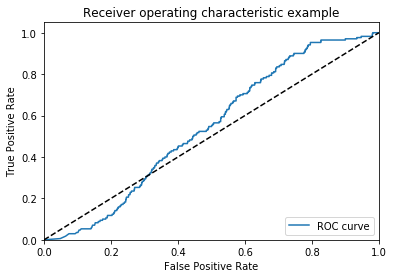

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = list(set(predictions['true']))
for c in classes[0:5]:
    y_true = predictions['true']==c
    y_pred = predictions['preds'][:,c]
    fpr[c], tpr[c], _ = roc_curve(y_true, y_pred)
    roc_auc[i] = auc(fpr[c], tpr[c])

In [ ]:
true = np.array()
scores = np.array()
for c in classes[0:3]:
    true = np.concatenate((true, y_true), axis=0)
    scores = np.concatenate((scores, y_pred), axis=0)

In [24]:
preds = np.array([[0.1,0.8,0.1],[0.5,0.4,0.1],[0.1,0.2,0.7]])
predictions = np.argmax(abs(preds),axis=1)
print(preds)
print(predictions)
preds[predictions,:]

[[0.1 0.8 0.1]
 [0.5 0.4 0.1]
 [0.1 0.2 0.7]]
[1 0 2]


array([[0.5, 0.4, 0.1],
       [0.1, 0.8, 0.1],
       [0.1, 0.2, 0.7]])

In [26]:
preds[np.arange(len(preds)), predictions]

array([0.8, 0.5, 0.7])

In [31]:
preds = np.array([[0.1,0.8,0.1],[0.5,0.4,0.1],[0.1,0.2,0.7]])
preds

array([[0.1, 0.8, 0.1],
       [0.5, 0.4, 0.1],
       [0.1, 0.2, 0.7]])

In [32]:
preds.ravel()

array([0.1, 0.8, 0.1, 0.5, 0.4, 0.1, 0.1, 0.2, 0.7])

In [35]:
preds+preds

array([[0.2, 1.6, 0.2],
       [1. , 0.8, 0.2],
       [0.2, 0.4, 1.4]])